<a href="https://colab.research.google.com/github/trehansalil/Py_Projects/blob/master/News_Summarization/experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pymongo[srv] transformers emoji rouge-score spacy seaborn scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.0/670.0 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.4/431.4 kB 40.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.7/307.7 kB 30.0 MB/s eta 0:00:00
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=688c6abf0e83f30208147824482b5ccb365e51c3e327086a0ed0edc0a0dc7b12
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [4]:
from pymongo import MongoClient
import pandas as pd
from datetime import datetime, timezone
import os
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, AutoTokenizer, BertModel, BertConfig, AutoModel, AdamW


# Requires the PyMongo package.
# https://api.mongodb.com/python/current

from google.colab import userdata
MONGO_DB_URI = userdata.get('MONGO_DB_URI')

client = MongoClient(MONGO_DB_URI)
filter={
    'updated_at': {
        '$gte': datetime(2023, 10, 1, 0, 0, 0, tzinfo=timezone.utc),
        '$lt': datetime(2025, 1, 1, 0, 0, 0, tzinfo=timezone.utc)
    },
    'category': {
        '$ne': []
    }
}
sort=list({
    'updated_at': -1
}.items())

result = client['inshorts_db']['news_data'].find(
  filter=filter,
  sort=sort
)

df = pd.DataFrame.from_dict(result)

irrelevant_categories = [i for i in df['category'].explode().value_counts().loc[df['category'].explode().value_counts()<1000].index]
relevant_categories = [i for i in df['category'].explode().value_counts().loc[df['category'].explode().value_counts()>=1000].index]

print(irrelevant_categories)

df['category'] = df['category'].apply(lambda x: [i for i in x if i not in irrelevant_categories])

df.drop(index=df.loc[df['category'].apply(lambda x: x==[])].index, inplace=True)

df = df.reset_index(drop=True)

df.head()

['IPL', 'Lifestyle', 'EXPLAINERS', 'Feel_Good_Stories', 'experiment', 'Israel-Hamas_War', 'cricket', 'city', 'Russia-Ukraine_Conflict', 'crime', 'bollywood', 'Coronavirus', 'cryptocurrency', 'football', 'arts_and_entertainment', 'facts', 'Union_Budget_2023-24', 'Union_Budget_2024', 'environment', 'ODI_World_Cup_2023']


,_id,inshorts_url,author,category,created_at,date,datetime,day,headlines,image_url,original_source,read_more,relevancy_tags,text,updated_at
0,66501bb07fcaca29f812e1cb,https://inshorts.com/en/news/7-of-a-family-kil...,Dharini Mudgal,[national],2024-05-24 14:58:59.722,2024-05-24,2024-05-24 03:34:13,Friday,"7 of a family killed, 20 hurt after bus rams i...",https://nis-gs.pix.in/inshorts/images/v1/varia...,X,https://x.com/ANI/status/1793838772796485738?u...,[national],Seven members of the same family were killed a...,2024-05-24 14:58:59.722
1,66501bb07fcaca29f812e096,https://inshorts.com/en/news/who-are-key-candi...,Nakul Ahuja,"[politics, LOK_SABHA_ELECTIONS, national]",2024-05-24 14:58:59.444,2024-05-24,2024-05-24 04:00:03,Friday,Who are key candidates as Delhi goes to polls ...,https://nis-gs.pix.in/inshorts/images/v1/varia...,Hindustan Times,https://www.hindustantimes.com/india-news/kanh...,"[national, politics]",Voting for all seven Lok Sabha seats in Delhi ...,2024-05-24 14:58:59.444
2,66501bb07fcaca29f812dfa7,https://inshorts.com/en/news/over-20-report-sp...,Swati Dubey,[world],2024-05-24 14:58:59.166,2024-05-24,2024-05-24 04:08:44,Friday,Over 20 report spine & brain injuries on Singa...,https://nis-gs.pix.in/inshorts/images/v1/varia...,The Indian Express,https://indianexpress.com/article/world/singap...,[world],Twenty-two of 229 people onboard a Singapore A...,2024-05-24 14:58:59.166
3,66501baf7fcaca29f812dead,https://inshorts.com/en/news/pune-teens-mother...,Shreyasi Banerjee,[national],2024-05-24 14:58:58.885,2024-05-24,2024-05-24 04:24:47,Friday,Pune teen's mother breaks down while dismissin...,https://nis-gs.pix.in/inshorts/images/v1/varia...,Free Press Journal,https://www.freepressjournal.in/amp/pune/pleas...,[national],"Shivani Agarwal, mother of the 17-year-old boy...",2024-05-24 14:58:58.885
4,66501baf7fcaca29f812dd30,https://inshorts.com/en/news/founders-looking-...,Ashley Paul,"[startup, technology]",2024-05-24 14:58:58.607,2024-05-24,2024-05-24 04:45:59,Friday,Founders looking to sell Humane weeks after AI...,https://nis-gs.pix.in/inshorts/images/v1/varia...,The Indian Express,https://indianexpress.com/article/technology/a...,"[startup, technology]",Former Apple employees Imran Chaudhri and Beth...,2024-05-24 14:58:58.607


In [5]:
df['category'].explode().value_counts()

category
national               5799
business               3826
sports                 3512
entertainment          2824
world                  2758
politics               2568
technology             1737
miscellaneous          1712
hatke                  1565
startup                1433
LOK_SABHA_ELECTIONS    1244
Health___Fitness       1172
travel                 1142
science                1140
fashion                1139
education              1053
automobile             1045
Name: count, dtype: int64

In [6]:
df['original_source'].value_counts()

original_source
Free Press Journal      1631
Times Now               1240
Hindustan Times         1238
The Indian Express       705
News18                   667
                        ... 
Kidney International       1
Health Ministry            1
OPCW                       1
spotboye.com               1
Mouawad                    1
Name: count, Length: 596, dtype: int64

In [7]:
df.drop(columns=['inshorts_url', 'author', 'created_at', 'updated_at',
                 'datetime', 'date', 'day', 'original_source',
                 'read_more', 'relevancy_tags'],inplace=True)

### News Summarization

In [8]:
import pandas as pd
import numpy as np
import spacy
from IPython.display import Image

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [9]:
config = {'min_text_len':40,
          'max_text_len':60,
          'max_summary_len':30,
          'latent_dim':300,
          'embedding_dim':200}

In [10]:
raw = df[['text', 'headlines']].rename(columns={'headlines': 'summary'})

raw

,text,summary
0,Seven members of the same family were killed a...,"7 of a family killed, 20 hurt after bus rams i..."
1,Voting for all seven Lok Sabha seats in Delhi ...,Who are key candidates as Delhi goes to polls ...
2,Twenty-two of 229 people onboard a Singapore A...,Over 20 report spine & brain injuries on Singa...
3,"Shivani Agarwal, mother of the 17-year-old boy...",Pune teen's mother breaks down while dismissin...
4,Former Apple employees Imran Chaudhri and Beth...,Founders looking to sell Humane weeks after AI...
...,...,...
24583,"The Congress in Kerala on Saturday, 20 April, ...",Congress to Press Council: Take action against...
24584,An old video of AIMIM leader Asaduddin Owaisi ...,Old video of Asaduddin Owaisi's speech edited ...
24585,A video showing Congress MP Shashi Tharoor dan...,Shashi Tharoor dances with crowd on 'Jai Ho' d...
24586,RJD leader Tejashwi Yadav reacted to PM Narend...,"He's talking about Hindu-Muslims, not real iss..."


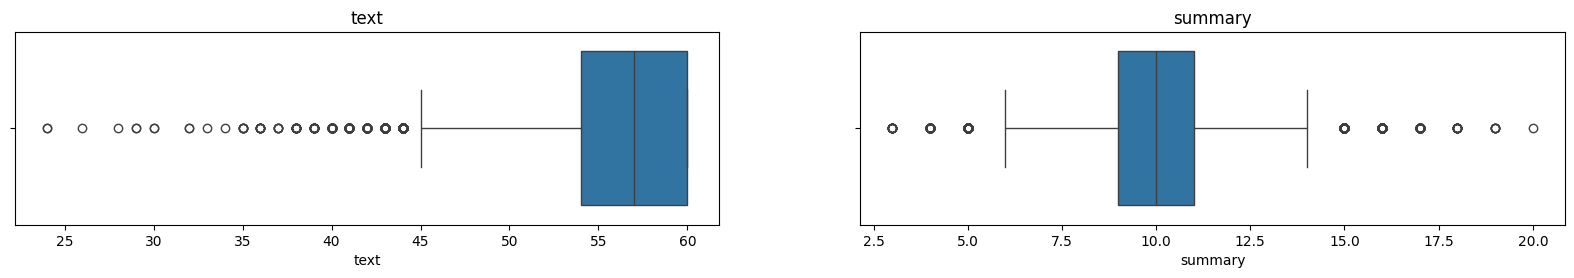

In [11]:
fig, ax = plt.subplots(1,2,figsize=(20,2.5))
sns.boxplot(raw['text'].str.split().str.len(),ax=ax[0],orient="h")
ax[0].set_title('text')
sns.boxplot(raw['summary'].str.split().str.len(),ax=ax[1],orient="h")
ax[1].set_title('summary')

fig.show()

In [12]:
print(f'berore filtering: {raw.shape}')
pre = raw.loc[(raw['text'].str.split(" ").str.len()>config['min_text_len']) & (raw['text'].str.split(" ").str.len()<config['max_text_len'])].reset_index(drop=True)
print(f'after filtering: {pre.shape}')

berore filtering: (24588, 2)
after filtering: (17841, 2)


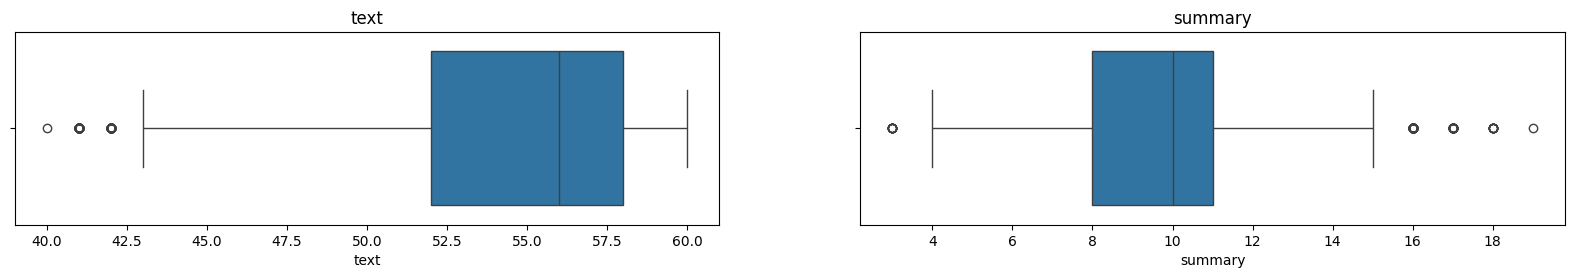

In [13]:
fig, ax = plt.subplots(1,2,figsize=(20,2.5))
sns.boxplot(pre['text'].str.split().str.len(),ax=ax[0],orient="h")
ax[0].set_title('text')
sns.boxplot(pre['summary'].str.split().str.len(),ax=ax[1],orient="h")
ax[1].set_title('summary')

fig.show()

In [14]:
ind = 1
print(f'Text: {pre.text[ind]}')
print('')
print(f'Summary: {pre.summary[ind]}')
print('')
print(f'Text length: {len(pre.text[ind].split())}')
print(f'Summary length: {len(pre.summary[ind].split())}')

Text: Twenty-two of 229 people onboard a Singapore Airlines flight hit by turbulence on May 21 suffered spinal injuries, and 6 sustained brain and skull injuries. Twenty people remain in intensive care with no life-threatening injuries, The Straits Times reported, citing Dr Adinun Kittiratanapaibool of Samitivej Srinakarin Hospital. While the oldest patient is 83, the youngest, 2, has a concussion.

Summary: Over 20 report spine & brain injuries on Singapore Airlines plane

Text length: 59
Summary length: 11


In [15]:
import nltk
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]    | Downloading package bcp47 to /root/nltk_data...
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   U

True

In [16]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Embedding, Input, InputLayer, RNN, SimpleRNN, LSTM, GRU, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf

import string

import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
stop_words = stopwords.words('english')

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
import re

# remove non-alphabetic character
def text_strip(sentence):

    sentence = re.sub("(\\t)"," ",str(sentence)).lower()
    sentence = re.sub("(\\r)"," ",str(sentence)).lower()
    sentence = re.sub("(\\n)"," ",str(sentence)).lower()

    # remove - if it occours more than one time
    sentence = re.sub("(--+)"," ",str(sentence)).lower()

    # remove . if it occours more than one time
    sentence = re.sub("(\.\.+)"," ",str(sentence)).lower()

    # remove special characters
    sentence = re.sub(r"[-<>()|&©⌀\[\]\'\",;?*!]"," ",str(sentence)).lower()

    # remove \x9* in text
    sentence = re.sub(r"(\\x9\d)"," ",str(sentence)).lower()

    # replace CH# and CHG# to CM_NUM
    sentence = re.sub("([cC][mM]\d+)|([cC][hH][gG]\d+)","CM_NUM",str(sentence)).lower()

    # remove punctuations at the end of the word
    sentence = re.sub("(\.\s+)"," ",str(sentence)).lower()
    sentence = re.sub("(\-\s+)"," ",str(sentence)).lower()
    sentence = re.sub("(\:\s+)"," ",str(sentence)).lower()

    # remove multiple spaces
    sentence = re.sub("(\s+)"," ",str(sentence)).lower()

    return sentence

In [18]:
pre['cleaned_text'] = pre.text.apply(lambda x: text_strip(x))
pre['cleaned_summary'] = pre.summary.apply(lambda x: '__START__' + text_strip(x) + '__END__')
pre['cleaned_summary'] = pre['cleaned_summary'].apply(lambda x: 'sostok ' + x + ' eostok')
pre

,text,summary,cleaned_text,cleaned_summary
0,Voting for all seven Lok Sabha seats in Delhi ...,Who are key candidates as Delhi goes to polls ...,voting for all seven lok sabha seats in delhi ...,sostok __START__who are key candidates as delh...
1,Twenty-two of 229 people onboard a Singapore A...,Over 20 report spine & brain injuries on Singa...,twenty two of 229 people onboard a singapore a...,sostok __START__over 20 report spine brain inj...
2,"Shivani Agarwal, mother of the 17-year-old boy...",Pune teen's mother breaks down while dismissin...,shivani agarwal mother of the 17 year old boy ...,sostok __START__pune teen s mother breaks down...
3,CSK fast bowler Tushar Deshpande took to his I...,CSK's Deshpande shares pic of 'Bengaluru Cant'...,csk fast bowler tushar deshpande took to his i...,sostok __START__csk s deshpande shares pic of ...
4,Ex-RCB captain Virat Kohli scored 741 runs in ...,How did Virat Kohli perform in IPL 2024 as com...,ex rcb captain virat kohli scored 741 runs in ...,sostok __START__how did virat kohli perform in...
...,...,...,...,...
17836,"Karnataka Chief Minister Siddaramaiah, on Mond...",Karnataka drought relief: Centre tells SC will...,karnataka chief minister siddaramaiah on monda...,sostok __START__karnataka drought relief centr...
17837,A Delhi court has declined CM Arvind Kejriwal'...,Court declines Kejriwal's plea seeking insulin...,a delhi court has declined cm arvind kejriwal ...,sostok __START__court declines kejriwal s plea...
17838,"The Congress in Kerala on Saturday, 20 April, ...",Congress to Press Council: Take action against...,the congress in kerala on saturday 20 april lo...,sostok __START__congress to press council take...
17839,A video showing Congress MP Shashi Tharoor dan...,Shashi Tharoor dances with crowd on 'Jai Ho' d...,a video showing congress mp shashi tharoor dan...,sostok __START__shashi tharoor dances with cro...


In [19]:
print(pre.shape)
post_pre = pre[((pre['cleaned_text'].str.split().str.len()<=config['max_text_len']) & (pre['summary'].str.split().str.len()<=(config['max_summary_len']+4)))].copy()
post_pre = post_pre.reset_index(drop=True)
print(post_pre.shape)
post_pre = post_pre.drop(['text','summary'],axis=1)
post_pre = post_pre.rename(columns = {'cleaned_text':'text',
                                      'cleaned_summary':'summary'})
post_pre

(17841, 4)
(15164, 4)


,text,summary
0,shivani agarwal mother of the 17 year old boy ...,sostok __START__pune teen s mother breaks down...
1,csk fast bowler tushar deshpande took to his i...,sostok __START__csk s deshpande shares pic of ...
2,as per us federal aviation administration s gu...,sostok __START__what should passengers do duri...
3,speaking at a panel discussion congress leader...,sostok __START__system is against lower castes...
4,on the recommendation of i4c and state law enf...,sostok __START__govt orders taking down of ove...
...,...,...
15159,union minister amit shah submitted his nominat...,sostok __START__lok sabha elections 2024 amit ...
15160,karnataka chief minister siddaramaiah on monda...,sostok __START__karnataka drought relief centr...
15161,the congress in kerala on saturday 20 april lo...,sostok __START__congress to press council take...
15162,a video showing congress mp shashi tharoor dan...,sostok __START__shashi tharoor dances with cro...


In [20]:
x_train, x_valid, y_train, y_valid = train_test_split(np.array(post_pre['text']),
                                                      np.array(post_pre['summary']),
                                                      test_size = 0.1,
                                                      shuffle=True)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((13647,), (1517,), (13647,), (1517,))

In [21]:

text_tokenizer = Tokenizer()
text_tokenizer.fit_on_texts(list(x_train))

In [22]:
def get_rare_words(text_col):

    # prepare a tokenizer on testing data
    text_tokenizer = Tokenizer()
    text_tokenizer.fit_on_texts(list(text_col))

    thresh = 5
    cnt = 0
    total_count = 0

    for key, value in text_tokenizer.word_counts.items():
        total_count = total_count + 1
        if value < thresh:
            cnt = cnt + 1

    print('% of rare words in vocabulary:',(cnt/total_count)*100)

    return cnt, total_count


x_train_cnt, x_train_total_count = get_rare_words(x_train)

% of rare words in vocabulary: 68.68390426554673


In [23]:
x_tokenizer = Tokenizer(num_words = x_train_total_count-x_train_cnt)
x_tokenizer.fit_on_texts(list(x_train))

# Convert text sequence to integer sequence
x_tr_seq = x_tokenizer.texts_to_sequences(x_train)
x_val_seq = x_tokenizer.texts_to_sequences(x_valid)

# pad zero upto maximum length
x_tr = pad_sequences(x_tr_seq, maxlen = config['max_text_len'],padding='post')
x_val = pad_sequences(x_val_seq, maxlen = config['max_text_len'],padding='post')

# Size of the vocab (+1 for padding)
x_voc = x_tokenizer.num_words +1

print('vocabulary size: ', x_voc)

vocabulary size:  12379


In [24]:

y_train_cnt, y_train_total_cnt = get_rare_words(y_train)

% of rare words in vocabulary: 76.46714551742485


In [25]:
y_tokenizer = Tokenizer(num_words = y_train_total_cnt-y_train_cnt)
y_tokenizer.fit_on_texts(list(y_train))

# Convert text sequence to integer sequence
y_tr_seq = y_tokenizer.texts_to_sequences(y_train)
y_val_seq = y_tokenizer.texts_to_sequences(y_valid)

# pad zero upto maximum length
y_tr = pad_sequences(y_tr_seq, maxlen = config['max_text_len'],padding='post')
y_val = pad_sequences(y_val_seq, maxlen = config['max_text_len'],padding='post')

# Size of the vocab (+1 for padding)
y_voc = y_tokenizer.num_words +1

print('vocabulary size: ',y_voc)

vocabulary size:  4424


In [26]:
latent_dim = config['latent_dim']
embedding_dim = config['embedding_dim']
max_text_len = config['max_text_len']
max_summary_len = config['max_summary_len']

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

# Embedding layer
enc_emb = Embedding(x_voc,embedding_dim,trainable=True)(encoder_inputs)

# Encoder LSTM 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
(encoder_output1,state_h,state_c) = encoder_lstm1(enc_emb)

# Encoder LSTM 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
(encoder_output2,state_h,state_c) = encoder_lstm2(encoder_output1)

# Encoder LSTM 3
encoder_lstm3 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
(encoder_outputs,state_h,state_c) = encoder_lstm3(encoder_output2)

# Decoder
decoder_inputs = Input(shape=(None, ))

# Embedding layer
dec_emb_layer = Embedding(y_voc,embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

# Decoder LSTM
decoder_lstm = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.2)
(decoder_outputs, decoder_fwd_state, decoder_back_state)= decoder_lstm(dec_emb,initial_state=[state_h,state_c])

# Dense Layer
decoder_dense = TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the Model
model = Model([encoder_inputs, decoder_inputs],decoder_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 60)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 60, 200)              2475800   ['input_1[0][0]']             
                                                                                                  
 lstm (LSTM)                 [(None, 60, 300),            601200    ['embedding[0][0]']           
                              (None, 300),                                                        
                              (None, 300)]                                                        
                                                                                              

In [27]:
model.compile(optimizer='adam',loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

model_name = './model.h5'

save_model = tf.keras.callbacks.ModelCheckpoint(filepath=model_name,
                                                save_weights_only=True,
                                                save_best_only=True,
                                                verbose=1)
# Eralystopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

In [28]:
history = model.fit(
    [x_tr,y_tr[:, :-1]],
    y_tr.reshape(y_tr.shape[0],y_tr.shape[1],1)[:, 1:],
    epochs =500,
    callbacks = [es, save_model],
    batch_size = 512,
    validation_data = ([x_val,y_val[:, :-1]],
                       y_val.reshape(y_val.shape[0],y_val.shape[1],1)[:, 1:])
                    )

Epoch 1/500
27/27 [==============================] - ETA: 0s - loss: 3.5441 - accuracy: 0.7871
Epoch 1: val_loss improved from inf to 1.27465, saving model to ./model.h5
27/27 [==============================] - 56s 1s/step - loss: 3.5441 - accuracy: 0.7871 - val_loss: 1.2746 - val_accuracy: 0.8132
Epoch 2/500
27/27 [==============================] - ETA: 0s - loss: 1.2648 - accuracy: 0.8178
Epoch 2: val_loss improved from 1.27465 to 1.18220, saving model to ./model.h5
27/27 [==============================] - 34s 1s/step - loss: 1.2648 - accuracy: 0.8178 - val_loss: 1.1822 - val_accuracy: 0.8296
Epoch 3/500
27/27 [==============================] - ETA: 0s - loss: 1.2018 - accuracy: 0.8271
Epoch 3: val_loss improved from 1.18220 to 1.14590, saving model to ./model.h5
27/27 [==============================] - 37s 1s/step - loss: 1.2018 - accuracy: 0.8271 - val_loss: 1.1459 - val_accuracy: 0.8321
Epoch 4/500
27/27 [==============================] - ETA: 0s - loss: 1.2479 - accuracy: 0.8228


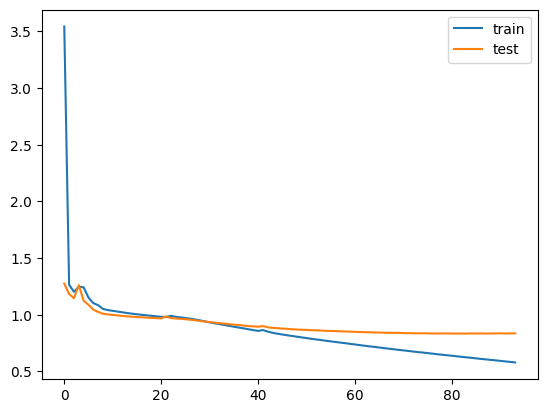

In [29]:
from matplotlib import pyplot

pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'],label='test')
pyplot.legend()
pyplot.show()

In [30]:
reverse_source_word_index = x_tokenizer.index_word
reverse_target_word_index = y_tokenizer.index_word
target_word_index = y_tokenizer.word_index

In [31]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2)

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [32]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [33]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [34]:
from tqdm import tqdm
actual = []
predicted = []
for i in tqdm(range(0,50)):
    print('Review:', seq2text(x_tr[i]))

    actual.append(seq2summary(y_tr[i]))
    print('Original Summary', actual[-1])

    predicted.append(decode_sequence(x_tr[i].reshape(1,config['max_text_len'])))
    print('Prdicted Summary', predicted[-1])
    print()

prediction_df = pd.DataFrame({'Actual':actual,'Predicted':predicted})
prediction_df.head(10)

  0%|          | 0/50 [00:00<?, ?it/s]

Review: chhattisgarh high court labels live in relationships as imported philosophy and contrary to indian norms affecting traditional marriage views the court dismissed abdul siddiqui s custody plea for his child from a live in relationship highlighting the cultural clash and legal complexities involved 
Original Summary start chhattisgarh hc live in clash with indian end 
1/1 [==============================] - 0s 29ms/step


  2%|▏         | 1/50 [00:02<01:50,  2.26s/it]

Prdicted Summary  start kerala police seize in telangana end

Review: rashmika mandanna has joined the cast of salman khan s upcoming film sikandar the actress took to her instagram to announce the news and said she is truly grateful and honoured to be a part of the project directed by ar sikandar which is by sajid nadiadwala marks the first collaboration between salman and rashmika 
Original Summary start confirmed rashmika joins salman khan in end 
1/1 [==============================] - 0s 31ms/step


  4%|▍         | 2/50 [00:04<01:38,  2.04s/it]

Prdicted Summary  start actress khan s son s wife s wife to her cover end

Review: amidst a north indian cold wave captivating videos on social media showcase a train gracefully snow covered tracks in jammu and kashmir the picturesque winter scenes unfold inviting viewers to the enchanting valley meanwhile delhi ncr battles a bone chilling cold wave with fog affecting visibility and creating a mesmerizing visual spectacle 
Original Summary start videos of snow tracks in j k go viral end 
1/1 [==============================] - 0s 75ms/step


  6%|▌         | 3/50 [00:06<01:35,  2.03s/it]

Prdicted Summary  start indian origin students killed in a truck end

Review: kolkata based popular chain wow has raised inr 70 cr 8 3 mn from homegrown investment firm wow cofounder krishnan told inc42 that the latest fundraise is an extension of the mega round raised by the startup earlier this year that saw participation from malaysian sovereign wealth fund and asset management 
Original Summary start bags inr 70 cr from end 
1/1 [==============================] - 0s 37ms/step


  8%|▊         | 4/50 [00:07<01:20,  1.75s/it]

Prdicted Summary  start raises crore in series a round end

Review: the consulate general of india in hong kong has issued a mandatory advisory for indian nationals planning short visits to the special administrative region sar this new regulation requires all indian travellers to spend up to 14 days in hong kong to complete an online pre arrival registration par before their departure 
Original Summary start indians headed to hong kong to online pre end 
1/1 [==============================] - 0s 20ms/step


 10%|█         | 5/50 [00:08<01:08,  1.52s/it]

Prdicted Summary  start what is the symptoms of the risk of end

Review: in a horrific incident that came to light in three car dealers were allegedly kidnapped by a gang and brutally tortured the videos of the car dealers suffering by the electric shocks to their private parts while they were naked have gone viral 
Original Summary start three car kidnapped with electric end 
1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 6/50 [00:09<00:58,  1.34s/it]

Prdicted Summary  start video man dies after falling off in hyderabad end

Review: sandy suffered from which is a condition that affects nerve that travel from the inner to the brain this usually happens due to a faulty gene the 18 month old received an which had a working copy of a faulty gene and the surgery took only 16 minutes 
Original Summary start world’s first gene therapy trial hearing in uk end 
1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 7/50 [00:10<00:53,  1.25s/it]

Prdicted Summary  start what is the symptoms of the symptoms of the world end

Review: swiggy has converted itself to a public limited company from a private entity ahead of its planned ipo the food delivery startup s name has changed from swiggy private limited to swiggy limited as per documents filed with the ministry of corporate affairs the startup reportedly plans to file a draft red in the coming months 
Original Summary start swiggy to public limited company ahead of ipo end 
1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 8/50 [00:11<00:50,  1.20s/it]

Prdicted Summary  start rbi s savings to get nod to operate as ceo end

Review: everyone still sharma for his in the 2007 t20 world cup final against pakistan now he is fulfilling his duties as the of in haryana police meanwhile is being appreciated for his move as haryana police has decided to cancel the passports and visas of those involved in violence during the protests 
Original Summary start netizens t20 wc hero sharma who is now end 
1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 9/50 [00:12<00:47,  1.15s/it]

Prdicted Summary  start t20 wc 2024 squad for t20 world cup 2024 end

Review: as the earnings season is underway listed companies are announcing their earnings for the january march quarter of the financial year 2023 24 some of these companies also declared monetary rewards as for their investors financial services also declared a whopping interim dividend of rs 240 per equity share for the financial year 2023 24 
Original Summary start rs dividend per share may 7 is record date end 
1/1 [==============================] - 0s 19ms/step


 20%|██        | 10/50 [00:13<00:44,  1.10s/it]

Prdicted Summary  start india s q1 profit growth in q4 revenue growth end

Review: nora fatehi recently spoke out against the behaviour of paparazzi in an interview expressing her of their habit of focusing on specific parts of her body the actress shared her feelings of being by the paparazzi stating i guess they ve never seen a b t like that before it is what it is 
Original Summary start nora fatehi calls out paparazzi for in on her body parts end 
1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 11/50 [00:14<00:40,  1.05s/it]

Prdicted Summary  start kareena kapoor khan of her in the world end

Review: a discovery has emerged from the of a mine in gujarat india scientists have unearthed the remains of one of the largest snakes ever recorded estimated to be between 11 and 15 metres long named after the associated with the hindu deity shiva this ancient reptile belonged to the family 
Original Summary start of one of the largest ever discovered in india end 
1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 12/50 [00:15<00:38,  1.00s/it]

Prdicted Summary  start the best of the way of your end

Review: csk fans have been thrilled to see ms dhoni in action during the ipl 2024 season however fans have been by his position in the batting order a recent report revealed that dhoni is dealing with a muscle tear in his leg which limits his ability to run freely the news of dhoni s injury raised concerns among fans 
Original Summary start ms dhoni’s presence in csk despite muscle raises questions end 
1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 13/50 [00:16<00:37,  1.02s/it]

Prdicted Summary  start rohit sharma s wife s team to reach ipl 2024 end

Review: russia has launched more than 2 000 drones at ukraine in the last six months a wall street journal report has claimed it also fired 135 missiles including 114 ballistic and 46 and missiles on ukraine the report stated however ukraine was reportedly able to shoot down only 46 of russian missiles 
Original Summary start russia fired 2 000 drones missiles on ukraine in 6 months report end 
1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 14/50 [00:17<00:35,  1.01it/s]

Prdicted Summary  start google fires 20 to employees for its own end

Review: uttarakhand cm pushkar singh dhami extended warm wishes on guru prakash honoring the sikh community s celebration taking to x formerly twitter he wrote congratulations and best wishes on the birth anniversary of the third guru of shri guru ji 
Original Summary start uttarakhand cm extends prakash greetings to community end 
1/1 [==============================] - 0s 30ms/step


 30%|███       | 15/50 [00:18<00:34,  1.01it/s]

Prdicted Summary  start pm modi extends navratri wishes on navami end

Review: congress lok sabha candidate from madhya pradesh s ratlam seat has said that if the party comes to power women will receive ₹1 lakh each those who have two wives will get ₹2 lakh he added reacting to his comment a social media user wrote every time i think they have hit lowest they surprise me 
Original Summary start will give ₹2 lakh to those with 2 congress lok sabha candidate end 
1/1 [==============================] - 0s 33ms/step


 32%|███▏      | 16/50 [00:19<00:37,  1.09s/it]

Prdicted Summary  start congress manifesto will be about muslim reservations end

Review: hacker has begun to return funds taken from a victim the hacker initially got away with 72 million worth of the hacker meanwhile will keep the remaining 10 which amounts to 7 2 million as a after with the victim crypto amounted to 1 7 billion last year dropped by over 50 from 2022 
Original Summary start bitcoin took then returns for 7 as end 
1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 17/50 [00:21<00:38,  1.17s/it]

Prdicted Summary  start india s april record 1 000 in india end

Review: an x user named dhawan with an specialist on she told netizens told him that i am experiencing neck and shoulder pain he asked me some questions around it and then wrote me a this is so sweet the post garnered several funny comments 
Original Summary start match writes pain relief for woman post viral end 
1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 18/50 [00:22<00:35,  1.10s/it]

Prdicted Summary  start video shows a of bjp s baby bump end

Review: officials of the greater hyderabad municipal corporation ghmc said it has no plan to bring back the hoardings that are double the size of the ones that existed earlier a ghmc official said that the new advertisement policy yet to be approved by the chief minister does not say that the size of the hoardings will be doubled 
Original Summary start in hyderabad not to be says ghmc end 
1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 19/50 [00:22<00:30,  1.01it/s]

Prdicted Summary  start meet the women of the end

Review: veteran rcb wicketkeeper dinesh karthik revealed he thought the ipl 2024 match against csk would be his last as rcb had lost seven of their first eight games they wouldn t qualify for the playoffs he invited 26 family members to watch however rcb s sensational turnaround winning six straight games secured their playoff spot 
Original Summary start dinesh karthik thought rcb vs csk would be his last ipl match end 
1/1 [==============================] - 0s 20ms/step


 40%|████      | 20/50 [00:24<00:32,  1.09s/it]

Prdicted Summary  start ipl 2024 shubman gill s t20 wc 2024 rohit sharma on virat kohli end

Review: pakistan pm shehbaz sharif has removed 25 senior tax officers from the federal board of revenue for corruption he took action against the senior officers based on inputs from three intelligence agencies about their lack of financial integrity and a report stated the move comes as pakistan grapples with an ongoing economic crisis 
Original Summary start pak pm sharif removes 25 senior tax officers for corruption report end 
1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 21/50 [00:25<00:30,  1.05s/it]

Prdicted Summary  start pm modi extends warm wishes on a day end

Review: udaipur is among the top 5 key rajasthan constituencies that has potential to make a difference to rajasthan s general election results udaipur is expected to be a tough battle between congress meena vs bjp s rawat udaipur was among the 13 seats of rajasthan that went to polls on april 26 
Original Summary start udaipur lok sabha elections 2024 key fights results end 
1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 22/50 [00:26<00:27,  1.00it/s]

Prdicted Summary  start telangana cm extends greetings on may 7 end

Review: ethylene oxide found in some spice mixes of everest and mdh in singapore and hong kong is a pesticide classified as a group 1 by the international agency for research on cancer it is highly and bacteria viruses and fungi the spice industry uses it to reduce contamination such as e and salmonella 
Original Summary start what is ethylene oxide found in samples of mdh everest spice end 
1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 23/50 [00:27<00:27,  1.01s/it]

Prdicted Summary  start imd warns of heavy rainfall in kerala and mahe end

Review: one introduces finance ki finance education for india s youth imagine learning finance through memes reels says vp dhar aiming to blend fun with empowering informed financial decisions targeting digital generation one aims to long term investment insights with 91 of india s gen z already planning their financial futures the brand said 
Original Summary start one s new venture one on financial awareness for gen z end 
1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 24/50 [00:27<00:23,  1.12it/s]

Prdicted Summary  start fm sitharaman discusses startup end

Review: time has released its annual list of the 100 most influential people in the world and several prominent indians and indian origin personalities secured a place in magazine s list for the year 2024 the list includes artists icons movie stars athletes scientists politicians and business leaders who have made an impact through their work 
Original Summary start indian origin people featured on time s 100 most influential list end 
1/1 [==============================] - 0s 19ms/step


 50%|█████     | 25/50 [00:28<00:19,  1.27it/s]

Prdicted Summary  start the first ever end

Review: indian fashion entrepreneur mona patel debuted on met gala red carpet this year with pictures of her mechanical butterfly dress going viral online the gujarat born entrepreneur wore a custom iris van outfit that had butterflies that their wings in slow motion patel who lives in us runs the non profit couture for cause 
Original Summary start pics of indian entrepreneur mona s butterfly dress at met gala 2024 go viral end 
1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 26/50 [00:29<00:21,  1.12it/s]

Prdicted Summary  start video shows mehta s son s son s wedding pics show end

Review: gland pharma ltd s shares surged 11 after reporting a 143 year on year net profit increase to crore and a 96 revenue rise to ₹1 crore in q4fy24 despite a 0 5 quarter on quarter revenue decline the company s performance significantly improved from the previous year s q4 
Original Summary start pharma net profit increased by yoy end 
1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 27/50 [00:30<00:20,  1.11it/s]

Prdicted Summary  start rupee to struggle on us dollar on thursday end

Review: electronics india is currently trading at rs 90 up by 13 60 points or 6 35 from its previous closing of rs 214 30 on the bse the scrip opened at rs 215 60 and has touched a high and low of rs 00 and rs 215 25 respectively so far shares were traded on the counter 
Original Summary start electronics india starts new store in telangana end 
1/1 [==============================] - 0s 27ms/step


 56%|█████▌    | 28/50 [00:31<00:20,  1.05it/s]

Prdicted Summary  start india s april 10 billion revenue in q4 end

Review: sunrisers hyderabad srh registered a dominant 10 wicket victory over lucknow super giants lsg in the indian premier league ipl 2024 match on wednesday post match footage captured lsg owner sanjiv goenka engaged in a heated conversation with rahul experts on jio cinema criticized the public display of frustration such conversations should be happening behind closed doors one expert said 
Original Summary start lsg public display of frustration raises end 
1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 29/50 [00:32<00:22,  1.09s/it]

Prdicted Summary  start video kohli s reaction to kkr s dismissal end

Review: speaking about its partnership with paytm axis bank ceo amitabh said the bank is working with the fintech company in three areas including upi business and as a nodal account manager for merchant transactions the next 3 to 6 months will tell us how the entire business out he said notably paytm has also partnered with yes bank 
Original Summary start next 6 months to tell how axis bank out with paytm end 
1/1 [==============================] - 0s 19ms/step


 60%|██████    | 30/50 [00:34<00:24,  1.21s/it]

Prdicted Summary  start zomato s firm to raise crore for its price end

Review: congress amethi lok sabha candidate kishori lal sharma stated that he would ve expanded his father s bakery had he not come to amethi my father established a bakery 70 years ago sharma said regarding his candidature from amethi he said i came to know about it after 12 am on may 3 the announcement was made during the day 
Original Summary start would ve father s had i not come to amethi sharma end 
1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 31/50 [00:35<00:22,  1.18s/it]

Prdicted Summary  start i am the of the best of the world s end

Review: srh opener abhishek sharma s parents missed his match against lsg in hyderabad after he booked their flight to the wrong city they were scheduled to come for this match but i booked them a flight for another location i had to book tickets for hyderabad but i booked for amritsar he said after the match 
Original Summary start srh s abhishek sharma s parents miss his ipl match as he books flight to wrong city end 
1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 32/50 [00:36<00:21,  1.17s/it]

Prdicted Summary  start video rohit sharma s wife to kkr s ipl 2024 match end

Review: actress priyanka chopra along with her husband nick jonas attended the valentino fall winter 2023 2024 show at the ongoing paris fashion week priyanka was seen in a plunging neckline dress while nick was seen in an all black valentino tailored suit both nick and priyanka shared pictures on their respective social media handles 
Original Summary start priyanka nick attend s show at paris fashion week end 
1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 33/50 [00:37<00:18,  1.10s/it]

Prdicted Summary  start priyanka chopra shares pics of her in mumbai end

Review: the indian two wheeler market has been shifting gears as sales have been in an hero motocorp ltd which announced its q4 results on may 8 plans to ride the momentum on the back of and revival in the rural economy in january march 2024 the operational profitability of hero motocorp grew 25 yoy to ₹1 359 crore 
Original Summary start hero motocorp bets on rural market boom for a ride end 
1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 34/50 [00:38<00:17,  1.12s/it]

Prdicted Summary  start india s april record record rs 1 lakh in april 2024 end

Review: star wars day falls on may 4 because of the may the fourth be with you which is similar to the often used in star wars may the force be with you so whether you re a seasoned fan or a to the force these facts will make you see star wars in a whole new light 
Original Summary start when is star day know facts about the star movies end 
1/1 [==============================] - 0s 21ms/step


 70%|███████   | 35/50 [00:39<00:15,  1.06s/it]

Prdicted Summary  start what is the best of the world end

Review: through seed series a and series b funding has raised a total of 21 million so far from innovation ventures blume ventures corporation global capital and the bengaluru based platform aims to use the fresh funds to expand to new markets and accelerate the commercial adoption of spot spray globally 
Original Summary start agritech startup bags 13 mn in series b end 
1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 36/50 [00:40<00:13,  1.02it/s]

Prdicted Summary  start raises crore in series a round end

Review: lamborghini has reported record sales in india with 92 units in 2022 it saw a growth of 33 from the previous year when it reported selling 69 units globally the company said 2022 saw the best sales figure ever and delivered 9 cars lamborghini recorded its previous best ever sales in india in 2021 and 2019 
Original Summary start lamborghini posts record sales in india in 2022 with units end 
1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 37/50 [00:41<00:13,  1.03s/it]

Prdicted Summary  start india s q1 sales in india to be by march 2024 end

Review: archaeologists have unearthed two ancient temples dating back to the period along with a rare in village of district telangana the temples estimated at least 1 300 years old showcase unique architectural styles blending and influences 
Original Summary start pics show 1 300 year old temples found in telangana end 
1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 38/50 [00:42<00:11,  1.02it/s]

Prdicted Summary  start the first timer s guide to the end

Review: as india aims to reach 300 billion electronics production by it will trigger demand for worth 90 100 billion largely driven by domestic mobile manufacturing an opportunity the country must tap in fy23 the total import of integrated circuits reached 16 14 billion out of which 12 billion was only for mobile phones 
Original Summary start india needs chips for goal end 
1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 39/50 [00:43<00:10,  1.01it/s]

Prdicted Summary  start apple to lay off in india s ev manufacturing end

Review: on being asked how to stick cheese to pizza google s ai suggested to add non toxic to pizza its response went viral on social media at least it recommends non toxic wrote one user this is a great reminder that ai is not a truth machine but just a very sophisticated tool wrote another 
Original Summary start use to stick to says google ai users react end 
1/1 [==============================] - 0s 28ms/step


 80%|████████  | 40/50 [00:44<00:09,  1.04it/s]

Prdicted Summary  start google lays off employees to employees end

Review: andhra pradesh congress committee chief ys sharmila on monday 29 april alleged that ysrcp president ys jagan mohan reddy and tdp head n chandrababu naidu are of the bjp sharmila made the allegation at a meeting in sharmila said the saffron party promised 10 special category status to andhra pradesh but cheated it 
Original Summary start chandrababu jagan of bjp end 
1/1 [==============================] - 0s 32ms/step


 82%|████████▏ | 41/50 [00:45<00:09,  1.08s/it]

Prdicted Summary  start bjp leader gowda s grandson prajwal revanna end

Review: congress puri lok sabha candidate sucharita mohanty returned her ticket after being denied funds for her campaign our party is having a serious fund crunch the party s accounts were frozen compared to the other two parties bjp and bjd we are no match congress is no match she said mohanty was a journalist before she entered politics in 2014 
Original Summary start congress no match to bjp puri candidate who returned ticket over funding end 
1/1 [==============================] - 0s 26ms/step


 84%|████████▍ | 42/50 [00:47<00:09,  1.17s/it]

Prdicted Summary  start bjp s madhavi latha s racist remark end

Review: has launched spring summer 23 collection stating that its best in class are innovative tech led these new breathe easy free offer comfort like never before it revealed when teamed up with shirts from the collection these every of a personality with their colours comfort craftsmanship it added 
Original Summary start there are and there are end 
1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 43/50 [00:47<00:07,  1.08s/it]

Prdicted Summary  start what are the symptoms of cancer causing end

Review: an 18 year old named died in jharkhand while attempting to create a viral instagram reel he jumped into a quarry lake from a 100 foot height and drowned following rescue attempts by friends and a subsequent search operation by the police s body was later recovered a video of the incident has gone viral 
Original Summary start teenager in attempt to create viral instagram reel end 
1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 44/50 [00:49<00:06,  1.09s/it]

Prdicted Summary  start man dies after falling off after falling off in delhi end

Review: model actress julia fox her outfit with her 20 month old son valentino for a new york fashion week show which was held on friday fox wore a black dress and thigh high pointed boots while her son wore a black and black fox shares her son with ex husband 
Original Summary start and her son wear outfits to new york fashion week end 
1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 45/50 [00:50<00:05,  1.16s/it]

Prdicted Summary  start video shows mehta actor gurucharan singh s son s son s death end

Review: describing the current status of the health infrastructure in the national capital and what is it a committee constituted by the delhi high court has filed a comprehensive interim report with recommendations to improve the medical services in delhi check out the reported issues and the measures recommended by the panel 
Original Summary start wrong with delhi’s health status report in hc end 
1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 46/50 [00:51<00:04,  1.14s/it]

Prdicted Summary  start i am i m on upsc civil services in 2023 end

Review: kartik aaryan released the trailer for his new film chandu champion in his hometown gwalior the stadium was packed with excited fans directed by kabir khan the film is about india s first gold medalist chandu champion showcases kartik as a boxer wrestler and soldier and releases on june 14 
Original Summary start kartik aaryan drops chandu champion trailer in gwalior end 
1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 47/50 [00:52<00:03,  1.09s/it]

Prdicted Summary  start deepika padukone serves outfit at cannes film festival end

Review: gauahar khan looked frustrated at the mumbai polling booth for the 2024 lok sabha elections as her name was missing from the voters list despite showing her aadhaar card she shared her ordeal on instagram questioning aadhaar s validity for voting eventually she cast her vote highlighting issues in the voting system 
Original Summary start gauahar says she wasn t allowed to vote despite having aadhaar end 
1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 48/50 [00:53<00:02,  1.02s/it]

Prdicted Summary  start priyanka chopra shares pics of her dress end

Review: liu was honored with the gold legend award at the gold house gala in los angeles for her contributions to film and the asian american community she received the award from king and discussed overcoming industry barriers the event also the movie and celebrated influential in american culture 
Original Summary start with gold legend award end 
1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 49/50 [00:53<00:00,  1.08it/s]

Prdicted Summary  start the of the ring and end

Review: the west indies international nicholas pooran continued his brilliant form smashing a half century in match against mi at the wankhede stadium the lsg batter reached his 50 off 19 balls and soon brought up his kiss celebration video of which was shared by ipl after being invited to bat first lsg posted 214 6 in 20 overs 
Original Summary start blows flying kiss after his 50 vs mi end 
1/1 [==============================] - 0s 18ms/step


100%|██████████| 50/50 [00:54<00:00,  1.10s/it]

Prdicted Summary  start video of the of the in the world end



,Actual,Predicted
0,start chhattisgarh hc live in clash with india...,start kerala police seize in telangana end
1,start confirmed rashmika joins salman khan in ...,start actress khan s son s wife s wife to her...
2,start videos of snow tracks in j k go viral end,start indian origin students killed in a truc...
3,start bags inr 70 cr from end,start raises crore in series a round end
4,start indians headed to hong kong to online pr...,start what is the symptoms of the risk of end
5,start three car kidnapped with electric end,start video man dies after falling off in hyd...
6,start world’s first gene therapy trial hearing...,start what is the symptoms of the symptoms of...
7,start swiggy to public limited company ahead o...,start rbi s savings to get nod to operate as ...
8,start netizens t20 wc hero sharma who is now end,start t20 wc 2024 squad for t20 world cup 202...
9,start rs dividend per share may 7 is record da...,start india s q1 profit growth in q4 revenue ...


In [36]:
from rouge_score import rouge_scorer

r_score = []
rouge_pr = []
rouge_rc = []
rouge_f = []

scorer = rouge_scorer.RougeScorer(['rougeL','rougeL'],use_stemmer=True)

for index, data in prediction_df.iterrows():
    r_score = scorer.score(data.Actual, data.Predicted)
    pr = list(r_score['rougeL'])[0]
    rc = list(r_score['rougeL'])[1]
    f_meas = list(r_score['rougeL'])[2]

    rouge_pr.append(pr)
    rouge_rc.append(rc)
    rouge_f.append(f_meas)

prediction_df['rouge_pr'] = rouge_pr
prediction_df['rouge_rc'] = rouge_rc
prediction_df['rouge_f'] = rouge_f
prediction_df.head(10)

,Actual,Predicted,rouge_pr,rouge_rc,rouge_f
0,start chhattisgarh hc live in clash with india...,start kerala police seize in telangana end,0.428571,0.333333,0.375000
1,start confirmed rashmika joins salman khan in ...,start actress khan s son s wife s wife to her...,0.230769,0.375000,0.285714
2,start videos of snow tracks in j k go viral end,start indian origin students killed in a truc...,0.333333,0.272727,0.300000
3,start bags inr 70 cr from end,start raises crore in series a round end,0.250000,0.285714,0.266667
4,start indians headed to hong kong to online pr...,start what is the symptoms of the risk of end,0.200000,0.200000,0.200000
5,start three car kidnapped with electric end,start video man dies after falling off in hyd...,0.200000,0.285714,0.235294
6,start world’s first gene therapy trial hearing...,start what is the symptoms of the symptoms of...,0.250000,0.272727,0.260870
7,start swiggy to public limited company ahead o...,start rbi s savings to get nod to operate as ...,0.250000,0.300000,0.272727
8,start netizens t20 wc hero sharma who is now end,start t20 wc 2024 squad for t20 world cup 202...,0.363636,0.400000,0.380952
9,start rs dividend per share may 7 is record da...,start india s q1 profit growth in q4 revenue ...,0.181818,0.181818,0.181818


In [39]:
prediction_df[['rouge_pr', 'rouge_rc', 'rouge_f']].mean(axis=0)

rouge_pr    0.287067
rouge_rc    0.271214
rouge_f     0.273471
dtype: float64

In [ ]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                       "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                       "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will",
                       "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am",
                       "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am",
                       "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have",
                       "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not",
                       "mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not",
                       "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
                       "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will",
                       "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have",
                       "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is",
                       "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would",
                       "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have",
                       "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have",
                       "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have",
                       "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did",
                       "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is",
                       "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                       "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
                       "y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have",
                       "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have", 'u.s':'america', 'e.g':'for example'}

punct = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£',
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…',
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─',
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞',
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]

punct_mapping = {"‘": "'", "₹": "e", "´": "'", "°": "", "€": "e", "™": "tm", "√": " sqrt ", "×": "x", "²": "2", "—": "-", "–": "-", "’": "'", "_": "-",
                 "`": "'", '“': '"', '”': '"', '“': '"', "£": "e", '∞': 'infinity', 'θ': 'theta', '÷': '/', 'α': 'alpha', '•': '.', 'à': 'a', '−': '-',
                 'β': 'beta', '∅': '', '³': '3', 'π': 'pi', '!':' '}

mispell_dict = {'colour': 'color', 'centre': 'center', 'favourite': 'favorite', 'travelling': 'traveling', 'counselling': 'counseling', 'theatre': 'theater',
                'cancelled': 'canceled', 'labour': 'labor', 'organisation': 'organization', 'wwii': 'world war 2', 'citicise': 'criticize', 'youtu ': 'youtube ',
                'Qoura': 'Quora', 'sallary': 'salary', 'Whta': 'What', 'narcisist': 'narcissist', 'howdo': 'how do', 'whatare': 'what are', 'howcan': 'how can',
                'howmuch': 'how much', 'howmany': 'how many', 'whydo': 'why do', 'doI': 'do I', 'theBest': 'the best', 'howdoes': 'how does',
                'mastrubation': 'masturbation', 'mastrubate': 'masturbate', "mastrubating": 'masturbating', 'pennis': 'penis', 'Etherium': 'Ethereum',
                'narcissit': 'narcissist', 'bigdata': 'big data', '2k17': '2017', '2k18': '2018', 'qouta': 'quota', 'exboyfriend': 'ex boyfriend',
                'airhostess': 'air hostess', "whst": 'what', 'watsapp': 'whatsapp', 'demonitisation': 'demonetization', 'demonitization': 'demonetization',
                'demonetisation': 'demonetization'}

In [ ]:
from bs4 import BeautifulSoup
import re
import emoji
import string

def clean_text(text):
    '''Clean emoji, Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = emoji.demojize(text)
    text = re.sub(r'\:(.*?)\:','',text)
    text = str(text).lower()    #Making Text Lowercase
    text = re.sub('\[.*?\]', '', text)
    #The next 2 lines remove html text
    # text = BeautifulSoup(text, 'lxml').get_text()
    # text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('\n', '', text)
    # text = re.sub('\w*\d\w*', '', text)
    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",", "'")
    # text = re.sub(r"[^a-zA-Z?.!,¿']+", " ", text)
    return text

def clean_contractions(text, mapping):
    '''Clean contraction using contraction mapping'''
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        text = text.replace(s, "'")
    for word in mapping.keys():
        if ""+word+"" in text:
            text = text.replace(""+word+"", ""+mapping[word]+"")
    #Remove Punctuations
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    text = re.sub(r"([?.!,¿])", r" \1 ", text)
    text = re.sub(r'[" "]+', " ", text)
    return text

def clean_special_chars(text, punct, mapping):
    '''Cleans special characters present(if any)'''
    for p in mapping:
        text = text.replace(p, mapping[p])

    for p in punct:
        text = text.replace(p, f' {p} ')

    specials = {'\u200b': ' ', '…': ' ... ', '\ufeff': '', 'करना': '', 'है': ''}
    for s in specials:
        text = text.replace(s, specials[s])

    return text

def correct_spelling(x, dic):
    '''Corrects common spelling errors'''
    for word in dic.keys():
        x = x.replace(word, dic[word])
    return x

def remove_space(text):
    '''Removes awkward spaces'''
    #Removes awkward spaces
    text = text.strip()
    text = text.split()
    return " ".join(text)

def text_preprocessing_pipeline(text):
    '''Cleaning and parsing the text.'''
    text = clean_text(text)
    text = clean_contractions(text, contraction_mapping)
    text = clean_special_chars(text, punct, punct_mapping)
    text = correct_spelling(text, mispell_dict)
    text = remove_space(text)
    return text

df['text'] = df['text'].apply(text_preprocessing_pipeline)

df_labels = df['category'].apply(lambda x: ",".join(x)).str.get_dummies(sep=',')

df = df.join(df_labels)

In [ ]:
len(irrelevant_categories)

19

In [ ]:
len(relevant_categories)

17

In [ ]:
target_cols = [i for i in df_labels.columns]

In [ ]:
import torch


device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [ ]:
# Sections of config

# Defining some key variables that will be used later on in the training
MAX_LEN = 200
TRAIN_BATCH_SIZE = 64
VALID_BATCH_SIZE = 64
EPOCHS = 10
LEARNING_RATE = 2e-5
tokenizer = AutoTokenizer.from_pretrained('roberta-base')

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
class BERTDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.df = df
        self.max_len = max_len
        self.text = df.Text
        self.tokenizer = tokenizer
        self.targets = df[target_cols].values

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
            text,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [ ]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df.drop(columns=['_id', 'headlines', 'image_url']), test_size=0.2, random_state=42)


In [ ]:
len(df_train['category'].explode().value_counts().index)

17

In [ ]:
len(df_test['category'].explode().value_counts().index)

17

In [ ]:

train_loader = DataLoader(df_train, batch_size=TRAIN_BATCH_SIZE,
                          num_workers=4, shuffle=True, pin_memory=True)
valid_loader = DataLoader(df_test, batch_size=VALID_BATCH_SIZE,
                          num_workers=4, shuffle=False, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model.

class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.roberta = AutoModel.from_pretrained('roberta-base')
#         self.l2 = torch.nn.Dropout(0.3)
        self.fc = torch.nn.Linear(768,5)

    def forward(self, ids, mask, token_type_ids):
        _, features = self.roberta(ids, attention_mask = mask, token_type_ids = token_type_ids, return_dict=False)
#         output_2 = self.l2(output_1)
        output = self.fc(features)
        return output

model = BERTClass()
model.to(device)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERTClass(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm

In [ ]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [ ]:
optimizer = AdamW(params =  model.parameters(), lr=LEARNING_RATE, weight_decay=1e-6)


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
def train(epoch):
    model.train()
    for _,data in enumerate(train_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        outputs = model(ids, mask, token_type_ids)

        loss = loss_fn(outputs, targets)
        if _%500 == 0:
            print(f'Epoch: {epoch}, Loss:  {loss.item()}')

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

In [ ]:
for epoch in range(EPOCHS):
    train(epoch)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


KeyError: Caught KeyError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pandas/core/indexes/base.py", line 3653, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas/_libs/index.pyx", line 147, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/index.pyx", line 176, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 7080, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 7088, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 3786

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/fetch.py", line 51, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/usr/local/lib/python3.10/dist-packages/pandas/core/frame.py", line 3761, in __getitem__
    indexer = self.columns.get_loc(key)
  File "/usr/local/lib/python3.10/dist-packages/pandas/core/indexes/base.py", line 3655, in get_loc
    raise KeyError(key) from err
KeyError: 3786


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MultiLabelBinarizer

import tensorflow as tf

class HammingLoss(tf.keras.metrics.Metric):
    def __init__(self, name='hamming_loss', threshold=0.5, mode='multilabel', **kwargs):
        super(HammingLoss, self).__init__(name=name, **kwargs)
        self.threshold = threshold
        self.mode = mode
        self.total_loss = self.add_weight(name='total_loss', initializer='zeros')
        self.count = self.add_weight(name='count', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        if self.mode == 'multilabel':
            y_pred = tf.cast(y_pred > self.threshold, tf.int32)
        elif self.mode == 'multiclassification':
            y_pred = tf.argmax(y_pred, axis=1)
            y_true = tf.argmax(y_true, axis=1)

        hamming_distance = tf.reduce_mean(tf.cast(y_true != y_pred, tf.float32))

        self.total_loss.assign_add(hamming_distance)
        self.count.assign_add(1)

    def result(self):
        return self.total_loss / self.count

    def reset_states(self):
        self.total_loss.assign(0)
        self.count.assign(0)



# Text Preprocessing
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df['text'])
X_text = tokenizer.texts_to_sequences(df['text'])
X_text = pad_sequences(X_text, padding='post')

# Category Preprocessing
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df['category'])

# Convert category labels to one-hot encoding
y = np.array(y)


model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64))
model.add(Dropout(0.5))
model.add(Dense(len(mlb.classes_), activation='sigmoid'))

metric = HammingLoss(mode='multilabel', threshold=0.8)

optimizer = tf.keras.optimizers.AdamW(
                learning_rate=0.001,
                weight_decay=0.004,
                beta_1=0.9,
                beta_2=0.999,
                epsilon=1e-07,
                amsgrad=False,
                clipnorm=None,
                clipvalue=None,
                global_clipnorm=None,
                use_ema=False,
                ema_momentum=0.99,
                ema_overwrite_frequency=None,
                loss_scale_factor=None,
                gradient_accumulation_steps=None,
                name='adamw',
            )

# Compiling the model
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', metric])

# Training the model
history = model.fit(X_text, y, epochs=10, batch_size=16, validation_split=0.2)


2024-05-19 18:25:17.806572: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-19 18:25:17.810026: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-19 18:25:17.842307: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-19 18:25:20.242522: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Epoch 1/10


TypeError: Input 'y' of 'NotEqual' Op has type int32 that does not match type int64 of argument 'x'.